In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import GPy
import csv
import pickle
import random
import math

from scipy.stats import norm, percentileofscore
from scipy import stats
from datetime import datetime
from statistics import mean 
from sklearn.metrics import mean_squared_error

### Loading inferred data

In [2]:
ds = pd.read_csv("data/predictions/ds_gaussian_clean.csv")
ds = ds.drop(['Unnamed: 0'], axis=1)

In [3]:
with open('data/predictionBase.pkl', 'rb') as inp:
    predictionBase = pickle.load(inp)
    
    
with open('data/predictableTimeseries.pkl', 'rb') as inp:
    predictableTimeseries = pickle.load(inp)
    

with open('data/gsimNumbersPredictionBase.pkl', 'rb') as inp:
    gsimNumbersPredictionBase = pickle.load(inp)
       

### Loading GSIM data

In [4]:
'''
This function loads the meta data, monhtly, yearly and seasonal data from the GSIM dataset for a gsim number
To each dataframe the gsim number is added for further identification.
Colum names are cleaned and a list of all dataframes is finally returned
'''
def loadTimeseries (series_name): 
    meta = gsim_metadata.loc[gsim_metadata['gsim.no'] == series_name]
    monthly = pd.read_csv("data/GSIM_indices/TIMESERIES/monthly/"+series_name+".mon", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    yearly = pd.read_csv("data/GSIM_indices/TIMESERIES/yearly/"+series_name+".year", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    seasonal = pd.read_csv("data/GSIM_indices/TIMESERIES/seasonal/"+series_name+".seas", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    monthly['gsim.no'] = series_name
    yearly['gsim.no'] = series_name
    seasonal['gsim.no'] = series_name
    monthly.columns, yearly.columns, seasonal.columns = monthly.columns.str.replace('"', ''), yearly.columns.str.replace('"', ''), seasonal.columns.str.replace('"', '')
    return [meta, monthly, yearly, seasonal]

In [5]:
'''
Transforms the last date of measurment for a season priveded in the gsim dataset as the feature date
As the seasonal gsim dataset stores the last date of measurement the last day of measurement of season DJF is in February, MAM in May and so on 
'''
def determimeSeason(date):
    endMonth = pd.to_datetime(date).month
    switcher = {
        2: "DJF",
        5: "MAM",
        8: "JJA",
        11: "SON"
    }
    return switcher.get(endMonth, "undefined")

In [6]:
# Loading the GSIM_metadata_Archive
gsim_metadata = pd.read_csv("data/GSIM_metadata/GSIM_catalog/GSIM_metadata.csv", sep=",")


# Selecting all the dataframes for South America by 2 Letter Country Code
southamerica2letterCC = ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE']

stations_of_interest = pd.Series()
for country in southamerica2letterCC: 
    stations_of_interest = stations_of_interest.append(gsim_metadata.loc[gsim_metadata['country'] == country]['gsim.no'], ignore_index=True)
        
    
# Initialisation of the empty lists where we store the dataframes: datatype: list of dataframes
df_yearly = []
df_monthly = []
df_seasonal = []
df_meta = []

# For each station in South America we load the meta, yearly, seasonal and monthly dataset
for station in stations_of_interest:
    
    series = loadTimeseries(station)
    df_meta.append(series[0])
    df_monthly.append(series[1])
    df_yearly.append(series[2])
    df_seasonal.append(series[3])

    
        
# For each dataframe in our monthly dataset we add a column that stores each the year and the month for a given measurement
for df in df_monthly: 
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date

    
# For each dataframe in our yearly dataset we add a column that stores the year for a given measurement
for df in df_yearly: 
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date


# For each dataframe in our seasonal dataset we add a column that stores the year and the season of the measurment. 
# Note that for the season DJF, the year is year of the months January and February is stored. 
for df in df_seasonal: 
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['season'] = [determimeSeason(date) for date in df['date']]
    
    
# Merge the list of metadataframes into one single dataframe, as for each station only one row of metadat exists we can merge them into one single dataframe
for index,meta in enumerate(df_meta):
    if index == 0:
        ds_meta = meta
    else: 
        ds_meta = ds_meta.append(meta, ignore_index = True)

### Temporal coverage

Presentation of the distribution of the temporal coverage of all stations in the GSIM in South America

In [7]:
soutamerica_yearly_coverage = np.zeros((len(df_meta)))
for index, meta in enumerate(df_meta):
    soutamerica_yearly_coverage[index] =  meta['year.no']
    

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


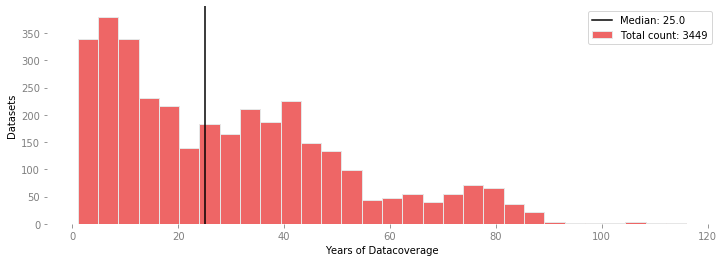

In [8]:
plt.figure(figsize=(12,4))
plt.xlabel('Years of Datacoverage')
plt.ylabel('Datasets')

# use a gray background
ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
ax.hist(soutamerica_yearly_coverage, edgecolor='#E6E6E6', color='#EE6666', bins=30);

unique, counts = np.unique(soutamerica_yearly_coverage, return_counts=True)
median = np.median(soutamerica_yearly_coverage)
plt.axvline(median, color="k")
plt.legend(['Median: ' + str(median), 'Total count: ' +  str(len(soutamerica_yearly_coverage))])
plt.show()

Presentation of when staions in South America stop measuring and have their last year of active recording 

In [9]:
soutamerica_endyear = np.zeros((len(df_meta)))
for index, meta in enumerate(df_meta): 
    soutamerica_endyear[index] = meta['year.end']

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


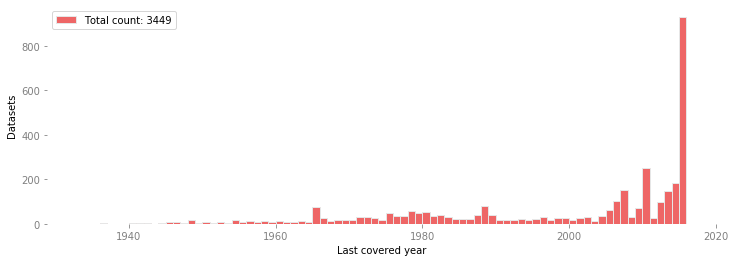

In [10]:
plt.figure(figsize=(12,4))
plt.xlabel('Last covered year')
plt.ylabel('Datasets')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
bins = int(max(soutamerica_endyear) - min(soutamerica_endyear))
ax.hist(soutamerica_endyear, edgecolor='#E6E6E6', color='#EE6666', bins=bins);
plt.legend(['Total count: ' +  str(len(soutamerica_endyear))])
plt.show()

In [11]:
#Adding a column in the yearly dataset, where the year is stored for each row
years = []
for dataset in df_yearly:
    dataset['year'] = pd.to_datetime(dataset['date']).dt.year
    years.extend(set(dataset['year'].tolist()))

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


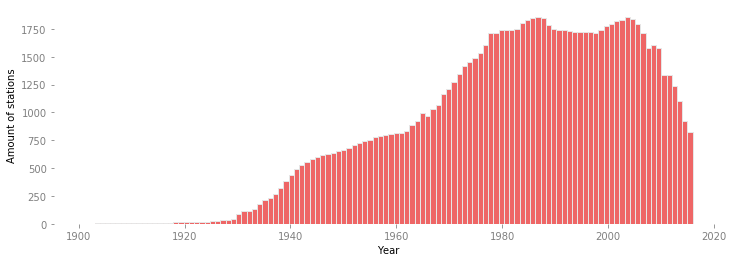

In [12]:
plt.figure(figsize=(12,4))
plt.xlabel('Year')
plt.ylabel('Amount of stations')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
ax.hist(years, edgecolor='#E6E6E6', color='#EE6666', bins=len(set(years)));
plt.show()

In [13]:
def get_range_of_years(lowerbound, upperbound):
    output = []
    for dataset in df_yearly:
        if lowerbound <= dataset.shape[0] < upperbound:
            output.extend(set(dataset['year'].tolist()))
    return output
    

In [14]:
plus60years = get_range_of_years(60,np.inf)
fourtyto59years = get_range_of_years(40,60)
twentyto39years = get_range_of_years(20,40)
lessthan20 = get_range_of_years(0,20)


In [15]:
colors = ['#264653', '#2a9d8f', '#e9c46a', '#e76f51']
allyears = np.array([plus60years,fourtyto59years, twentyto39years, lessthan20])

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


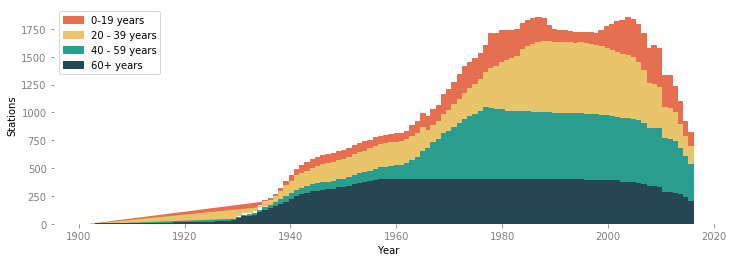

In [16]:
# Todo .. for those years that are not within one category like 1901 in 40-60 or so .. simply add 0 to them such that we can eliminate the artifact
# maybe think about another way of presenting the data. 
# like plotting multiple histograms on top of each other

plt.figure(figsize=(12,4))
plt.xlabel('Year')
plt.ylabel('Stations')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
bins = max(allyears.any()) - min(allyears.any())
labels = ['0-19 years', '20 - 39 years', '40 - 59 years', '60+ years']
ax.hist(allyears, color=colors, bins = bins+1,  histtype='step', stacked=True, fill=True);
plt.legend(labels, loc =2)
plt.show()

### Maximum discharge

In [17]:
def get_max_years (dataset, min_years):
    max_years = []
    for df in dataset:
        if df.shape[0] >= min_years:
            arr = df['MEAN'].to_numpy()
            arr_ = np.nan_to_num(arr, copy=True)
            maxind = np.argmax(arr_)
            if df['MEAN'].loc[maxind] == np.nan:
                raise Exception('x should not exceed 5. The value of x was: {}'.format(x))
            else:        
                max_years.append(df['year'].loc[maxind])
        else: 
            continue
    
    m = np.unique(max_years, return_counts=True)
    return m

In [18]:
def get_all_years (dataset, min_years):
    allyears = []
    for index, df in enumerate(df_yearly):
        if df.shape[0] >= min_years:
            years = df.loc[df['MEAN'].notnull()]['year'].to_numpy()
            allyears.extend(years)
        else: 
            continue
        
    a = np.unique(allyears, return_counts=True)
    return a
    

In [19]:
def get_norm_years (ma,al):
    n = np.zeros(len(ma[0]))
    
    for idx, year in enumerate(ma[0]):
        max_discharge = ma[1][idx]
        if max_discharge != 0: 
            all_years = al[1][al[0] == year][0]
            norm = max_discharge/all_years 
            n[idx] = norm
        else: 
            n[idx] = 0
    
    return n

In [20]:
m0  = get_max_years(df_yearly, 0)
m10 = get_max_years(df_yearly, 10)
m20 = get_max_years(df_yearly, 20)
m30 = get_max_years(df_yearly, 30)
m40 = get_max_years(df_yearly, 40)
m50 = get_max_years(df_yearly, 50)
m60 = get_max_years(df_yearly, 60)
m70 = get_max_years(df_yearly, 70)

In [21]:
a0  = get_all_years(df_yearly, 0)
a10 = get_all_years(df_yearly, 10)
a20 = get_all_years(df_yearly, 20)
a30 = get_all_years(df_yearly, 30)
a40 = get_all_years(df_yearly, 40)
a50 = get_all_years(df_yearly, 50)
a60 = get_all_years(df_yearly, 60)
a70 = get_all_years(df_yearly, 70)

In [22]:
n0 = get_norm_years(m0, a0)
n10 = get_norm_years(m10, a10)
n20 = get_norm_years(m20, a20)
n30 = get_norm_years(m30, a30)
n40 = get_norm_years(m40, a40)
n50 = get_norm_years(m50, a50)
n60 = get_norm_years(m60, a60)
n70 = get_norm_years(m70, a70)

<BarContainer object of 89 artists>

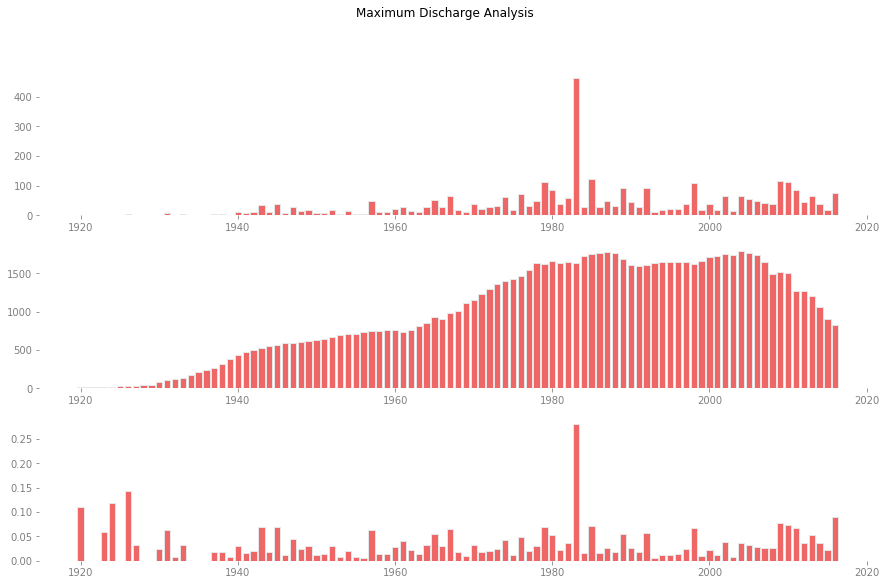

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m0[0], m0[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0[0][19:], a0[1][19:], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0[0], n0, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


<BarContainer object of 83 artists>

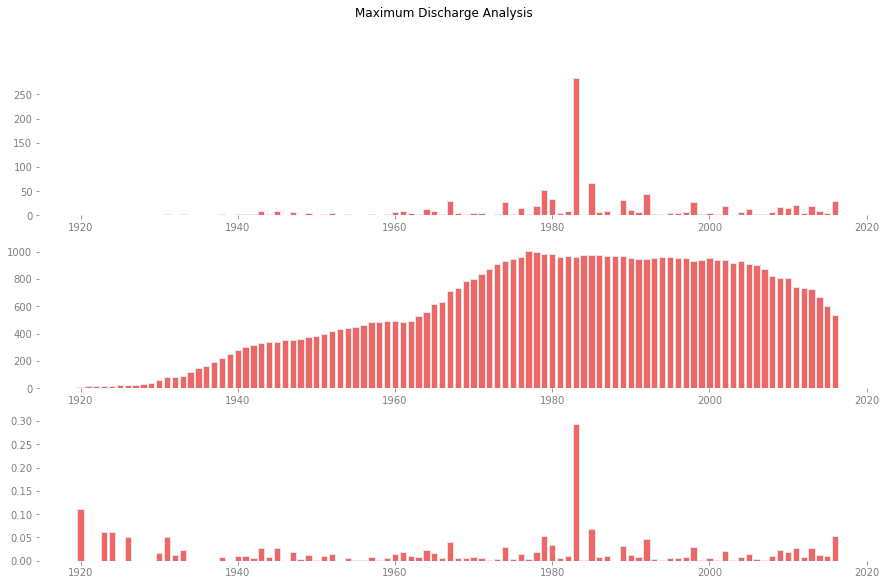

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m40[0], m40[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a40[0][19:], a40[1][19:], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m40[0], n40, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


### Transformation steps during Gaussian Normalisation

In [25]:
"""
Normalizes the data to a Gaussian distribution using quantiles. (function provided by Bedartha Goswami)
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [26]:
predictionBase[0]

,date,MEAN,SD,CV,IQR,MIN,MAX,MIN7,MAX7,n.missing,n.available,gsim.no,month,year
0,1960-01-31,12601.732258,1208.305023,0.095884,2113.02000,10622.020,14430.200,10128.115000,14101.840000,0,31,BR_0000078,1,1960
1,1960-02-29,14396.934138,247.026708,0.017158,235.57000,13760.620,14619.110,14032.572857,14605.572857,0,29,BR_0000078,2,1960
2,1960-03-31,13999.500968,457.025156,0.032646,450.55000,13070.770,14571.710,13253.682857,14480.744286,0,31,BR_0000078,3,1960
3,1960-04-30,12763.160667,192.896588,0.015114,359.46000,12449.090,13114.480,12533.584286,13149.421429,0,30,BR_0000078,4,1960
4,1960-05-31,12624.747419,600.664098,0.047578,937.78000,11429.330,13224.240,11686.385714,13208.531429,0,31,BR_0000078,5,1960
5,1960-06-30,8562.883800,1437.882959,0.167920,2057.45125,6653.374,11213.620,7042.049000,11580.974286,0,30,BR_0000078,6,1960
6,1960-07-31,4261.057677,1185.832583,0.278295,1717.67300,2578.497,6541.584,2857.694571,6917.213286,0,31,BR_0000078,7,1960
7,1960-08-31,1782.284677,411.052306,0.230632,700.47450,1352.604,2514.289,1381.777286,2757.707143,0,31,BR_0000078,8,1960
8,1960-09-30,1304.195933,57.677700,0.044225,87.65375,1245.255,1409.672,1245.710143,1406.333714,0,30,BR_0000078,9,1960
9,1960-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,0,BR_0000078,10,1960


In [27]:
timeseries = df_monthly[100]
tsMEAN = timeseries['MEAN'].to_numpy()
tsMEAN_toGaussian = normalizeToGaussian(tsMEAN)
tsMEAN_precentiles = norm.cdf(tsMEAN_toGaussian)

 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning:invalid value encountered in greater_equal


 C:\Users\marku\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()


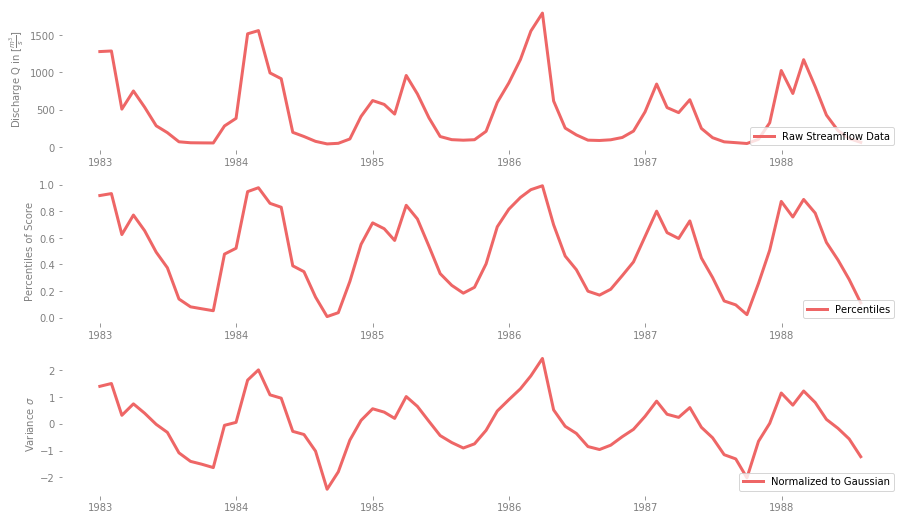

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

timespan = timeseries['date']


ax1.plot(timespan, tsMEAN, color='#EE6666', label = 'Raw Streamflow Data', linewidth=3 )
ax1.set_ylabel(r'Discharge Q in $[\frac{m^{3}}{s}]$', color='gray')
ax2.plot(timespan, tsMEAN_precentiles, color='#EE6666', label = 'Percentiles', linewidth=3 )
ax2.set_ylabel(r'Percentiles of Score',  color='gray')
ax3.plot(timespan, tsMEAN_toGaussian, color='#EE6666', label = 'Normalized to Gaussian', linewidth=3 )
ax3.set_ylabel(r'Variance $\sigma$',  color='gray')

ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

#plt.savefig('plots/TransformationSteps.svg', )

 C:\Users\marku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:invalid value encountered in greater_equal
 C:\Users\marku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:invalid value encountered in less_equal


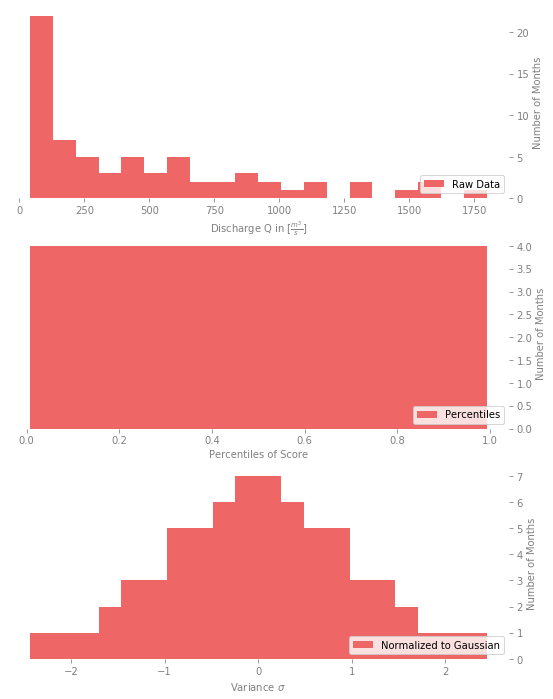

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,12))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)
    
ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

timespan = timeseries['date']
    

ax1.hist( tsMEAN, color='#EE6666', label = 'Raw Data', bins = 20)
ax1.set_xlabel(r'Discharge Q in $[\frac{m^{3}}{s}]$', color='gray')
ax1.set_ylabel('Number of Months', color='gray')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax2.hist( tsMEAN_precentiles, color='#EE6666', label = 'Percentiles', bins= 17)
ax2.set_xlabel(r'Percentiles of Score',  color='gray')
ax2.set_ylabel('Number of Months', color='gray')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax3.hist( tsMEAN_toGaussian, color='#EE6666', label = 'Normalized to Gaussian', bins = 20 )
ax3.set_xlabel(r'Variance $\sigma$',  color='gray')
ax3.set_ylabel('Number of Months', color='gray')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

#plt.savefig('plots/Distribution.svg', )

### Check for different attributes other than monthly mean river discharge

During the analysis we focuse mainly on the monthly mean streamflow values. 

In this section we want to analyse other attributes provided by the GSIM dataset

In [30]:
def get_max_years (dataset, min_years, feature):
    max_years = []
    for df in dataset:
        if df.shape[0] >= min_years:
            arr = df[feature].to_numpy()
            arr_ = np.nan_to_num(arr, copy=True)
            maxind = np.argmax(arr_)
            if df[feature].loc[maxind] == np.nan:
                raise Exception('x should not exceed 5. The value of x was: {}'.format(x))
            else:        
                max_years.append(df['year'].loc[maxind])
        else: 
            continue
    
    m = np.unique(max_years, return_counts=True)
    return m

In [31]:
def get_all_years (dataset, min_years, feature):
    allyears = []
    for index, df in enumerate(df_yearly):
        if df.shape[0] >= min_years:
            years = df.loc[df[feature].notnull()]['year'].to_numpy()
            allyears.extend(years)
        else: 
            continue
        
    a = np.unique(allyears, return_counts=True)
    return a
    

In [32]:
def get_norm_years (ma,al):
    n = np.zeros(len(ma[0]))
    
    for idx, year in enumerate(ma[0]):
        max_discharge = ma[1][idx]
        if max_discharge != 0: 
            all_years = al[1][al[0] == year][0]
            norm = max_discharge/all_years 
            n[idx] = norm
        else: 
            n[idx] = 0
    
    return n

#### Plots for the feature MEAN

In [33]:
m0_mean = get_max_years(df_yearly, 0, 'MEAN')
a0_mean = get_all_years(df_yearly, 0, 'MEAN')
n0_mean = get_norm_years(m0_mean,a0_mean)

<BarContainer object of 89 artists>

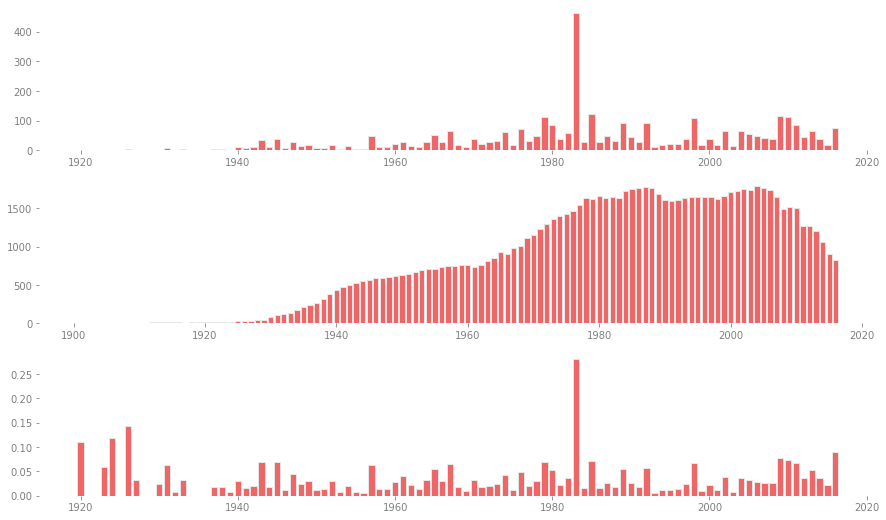

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

ax1.bar( m0_mean[0], m0_mean[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_mean[0], a0_mean[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_mean[0], n0_mean, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature MAX

In [35]:
m0_max = get_max_years(df_yearly, 0, 'MAX')
a0_max = get_all_years(df_yearly, 0, 'MAX')
n0_max = get_norm_years(m0_max,a0_max)

<BarContainer object of 93 artists>

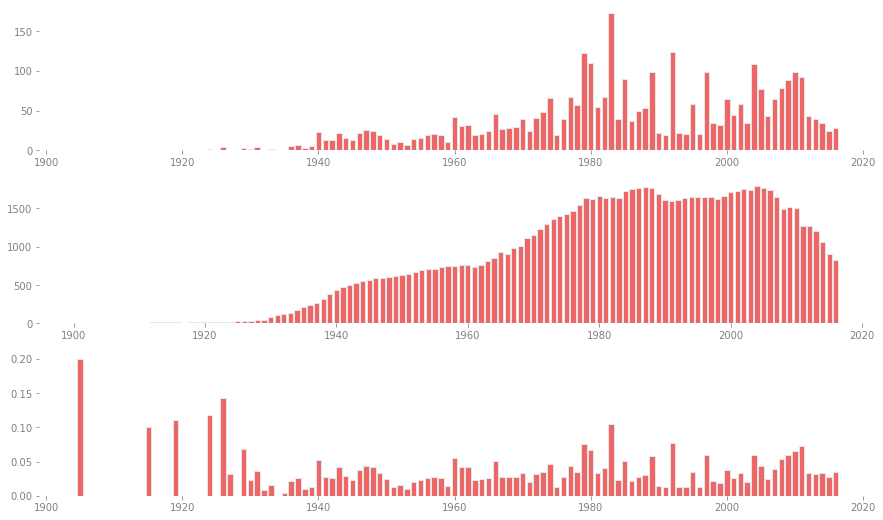

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

ax1.bar( m0_max[0], m0_max[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_max[0], a0_max[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_max[0], n0_max, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature MAX7

In [37]:
m0_max7 = get_max_years(df_yearly, 0, 'MAX7')
a0_max7 = get_all_years(df_yearly, 0, 'MAX7')
n0_max7 = get_norm_years(m0_max7,a0_max7)

<BarContainer object of 92 artists>

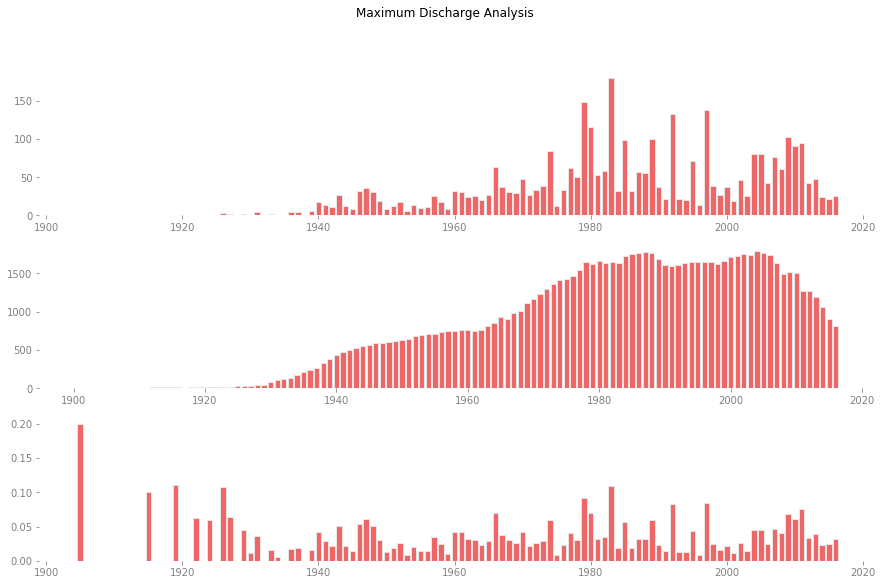

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m0_max7[0], m0_max7[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_max7[0], a0_max7[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_max7[0], n0_max7, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature DOYMAX

In [39]:
m0_doymax = get_max_years(df_yearly, 0, 'DOYMAX')
a0_doymax = get_all_years(df_yearly, 0, 'DOYMAX')
n0_doymax = get_norm_years(m0_doymax, a0_doymax)

<BarContainer object of 95 artists>

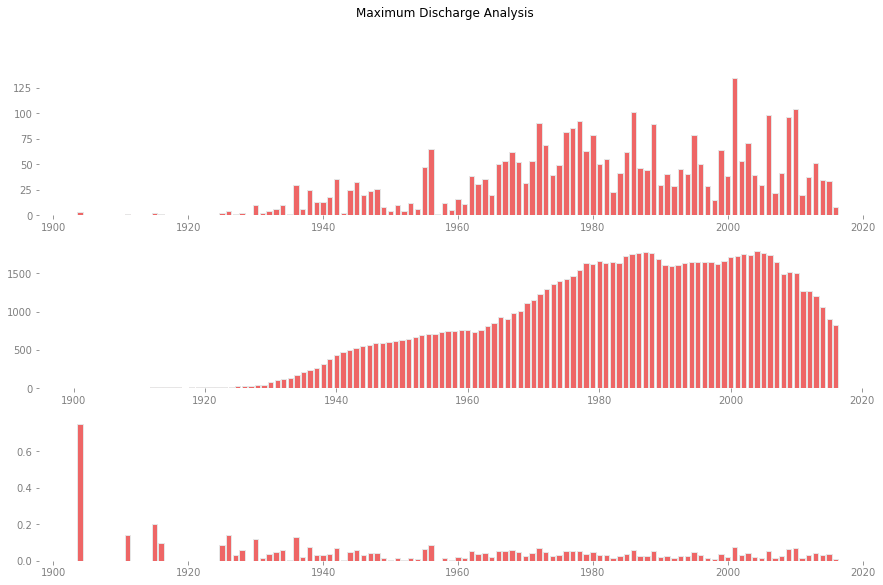

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m0_doymax[0], m0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_doymax[0], a0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_doymax[0], n0_doymax, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature DOYMAX7

In [41]:
m0_doymax = get_max_years(df_yearly, 0, 'DOYMAX7')
a0_doymax = get_all_years(df_yearly, 0, 'DOYMAX7')
n0_doymax = get_norm_years(m0_doymax, a0_doymax)

<BarContainer object of 96 artists>

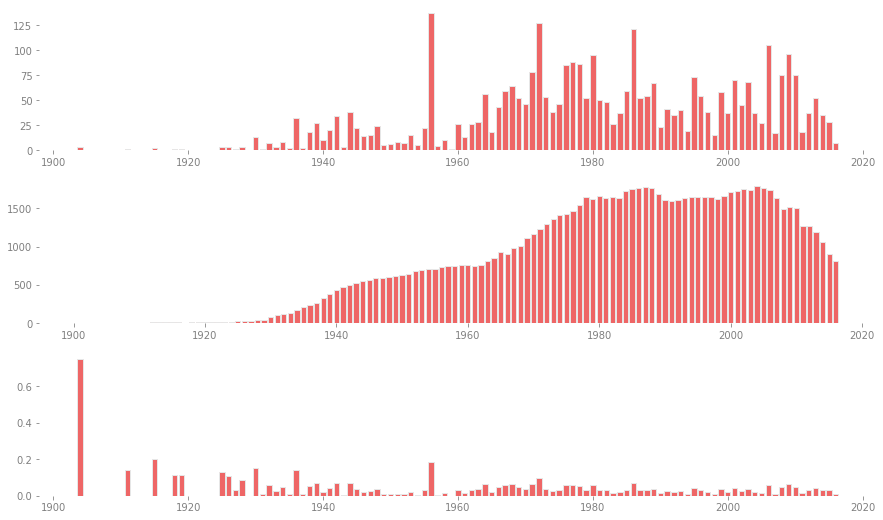

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
ax1.bar( m0_doymax[0], m0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_doymax[0], a0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_doymax[0], n0_doymax, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


### RMSE analysis

In [43]:
# Warning!
# Running the RMSE analysis for all dimensions from 5 -15 takes several hours, as each dimension takes roughly 1h to compute

In [44]:
START = datetime.strptime('1960-01-01', "%Y-%m-%d").date()
END =  datetime.strptime('2016-05-31', "%Y-%m-%d").date()
NUMBER_OF_DIMENSIONS = 10
TRAIN_TEST_THRESHOLD = 0.70
SAMPLESIZE = 1000
MIN_MONTHS_OF_OVERLAP = 60
MIN_YEARS_OF_OVERLAP = 5

In [45]:
"""
Normalizes the data to a Gaussian distribution using quantiles. (function provided by Bedartha Goswami)
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [46]:
'''
In order to perform a spearmans correlation we need to truncate our predictionBase to the same timespan of our dataframe we want to process. 
This truncation happens here.
'''
def truncateBase (dataframe, base):
    start = dataframe['date'].iloc[0]
    end   = dataframe['date'].iloc[-1]
    filtered_base = [df.loc[(df['date'] >= start) & (df['date'] <= end)]  for df in base]
    
    return filtered_base

In [47]:
'''
replaces missing values in the dataframe with the mean of the month for all years from which we have data
@param dataframe
@returns dataframe
'''
def averageNaNs (df):
    mean_df = df.groupby(['month']).mean()
    averaged_mean = df['MEAN'].copy().fillna(df['month'].map({1: mean_df['MEAN'][1] , 2: mean_df['MEAN'][2], 3:mean_df['MEAN'][3],
                                                    4: mean_df['MEAN'][4] , 5: mean_df['MEAN'][5], 6:mean_df['MEAN'][6], 
                                                    7: mean_df['MEAN'][7] , 8: mean_df['MEAN'][8], 9:mean_df['MEAN'][9],
                                                    10: mean_df['MEAN'][10] , 11: mean_df['MEAN'][11], 12:mean_df['MEAN'][12]}))
    
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [48]:
'''
Computation of Spearmas Rank Correlation
@param  target_df: a pandas.dataframe (target) for wich we want to calculate the correlation matrix 
        dataset: a list of pandas dataframes that build our base, as we check for the correlation between dataframe and each df in a dataset
@returns spearmans_matrix: a numpy.ndarray that contains the correlation value as first entry in each row and the corresponding p-value as a second element in each row. 
                            the order of the matrix is like in the dataset:
'''
def spearmansCorrelation (target_df, truncated_dataset): 
    spearmans_matrix = np.zeros((len(truncated_dataset), 2))
    for index, df in enumerate(truncated_dataset): 
        if (target_df.shape[0]!= df.shape[0]) or (df['MEAN'].isnull().all()):
            spearmans_matrix[index] = 0,100 
            continue
        else: 
            correlation, pval = stats.spearmanr(target_df['MEAN'], df['MEAN'], nan_policy='omit')
            spearmans_matrix[index] = correlation,pval    
            
    return spearmans_matrix

In [49]:
'''
Helper function to obtain the indices that show highest correlation 
@param dataframe
@returns list of correlation and p-values for each df, the indices that are above the threshold and the amount of dimensions
'''
def getIndices (spearmans_matrix, dim): 
    corr = spearmans_matrix[:,0].copy()
    indices = corr.argsort()[-dim:][::-1]
    if indices.size < dim:
        print("Less than {} timeseries while trying to get the indices".format(dim))
    
    return indices

In [50]:
'''
Based on a dataframe for which we want to fill missing values we select the most correlated timeseries of our prediction base
Then we transform and truncate the time serires so that we get input output mappings for training, and sets of input timeseries
for the time before and after the active timespan of our dataframe for which we want to infer missing data.
@param
@returns 
'''
def getDataForTrainingAndPredicting (dataframe, indices): 
    
    X_train  = []
    X_test   = []
    
    dim = indices.size
    start = dataframe['date'].iloc[0]
    end = dataframe['date'].iloc[-1]
    
    mostCorrelatedTimeseries = [predictionBase[index] for index in indices]
    
    splitind_df = int(dataframe.shape[0] * TRAIN_TEST_THRESHOLD)
    startind = max(0, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == start].index.values[0])
    splitind = startind + splitind_df 
    endind = min(mostCorrelatedTimeseries[0].shape[0] -1, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == end].index.values[0] +1)

    datesTest = mostCorrelatedTimeseries[0]['date'][splitind : endind]
    
    for ts in mostCorrelatedTimeseries: 
        tsNormalized = normalizeToGaussian(ts['MEAN'].copy().to_numpy())
        x_train = tsNormalized[startind: splitind].copy()
        
        x = normalizeToGaussian(averageNaNs(ts)).reshape(-1,1)
        x_test = x[splitind: endind].copy()
        
        X_train.append(x_train)
        X_test.append(x_test)

    X_test = np.column_stack((X_test))
    X_train = np.column_stack((X_train))
    
    Y_test = normalizeToGaussian(averageNaNs(dataframe))[splitind_df:].copy().reshape(-1,1)    
    Y_train  = normalizeToGaussian(dataframe['MEAN'].copy().to_numpy())[:splitind_df].reshape(-1,1) 
    
    
    train = np.concatenate((X_train,Y_train), axis=1)
    train_clean = train.copy()[~np.isnan(train).any(axis=1)]
    Y_train = train_clean[:,-1].reshape(-1,1)
    X_train = train_clean[:,:dim]

    return   X_train, X_test, Y_train, Y_test

In [51]:
def trainGP (X_train, Y_train, dim):
    kernel = GPy.kern.Matern32(input_dim = dim )
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=10)    
    return model

In [52]:
randomListOfIndices =  [random.randint(0, len(predictableTimeseries)) for i in range(500)] 

In [ ]:
# Warning! Running this cell takes some time
# During each iteration 500 GP models are trained such that we can compute the distribution of rmse values for this dimension

rmseList = []
for dim in range(5,16):
    rmseArray= np.zeros((len(randomListOfIndices)))
    predictionError=[]
    for counter, index in enumerate(randomListOfIndices):
        print(counter)
        df = predictableTimeseries[index]
        gsimNo = predictableTimeseries[index]['gsim.no'].any()
        truncatedBase = truncateBase (df, predictionBase)
        try:
            spearmansMatrix = spearmansCorrelation(df, truncatedBase)
        except:
            print("Could not compute spearmans matrix, for df {}".format(gsimNo))
            continue
            
        indices = getIndices(spearmansMatrix, dim)
        
        X_train, X_test, Y_train, Y_test = getDataForTrainingAndPredicting (df, indices)
        try:
            model = trainGP(X_train, Y_train, dim)
        except:
            print("could not train the model for df {}".format(gsimNo))
            continue
            
        mean, cov = model.predict(X_test)
    
        if mean.shape != Y_test.shape:
            Y_test = Y_test.copy()[:mean.shape[0]]
    
        rmseArray[counter] = math.sqrt(mean_squared_error(Y_test, mean))
        
    rmseList.append(rmseArray)
    with open ('data/predictions/rmse/rmsePredictionDim{}.pkl'.format(dim), 'wb') as outp:
        pickle.dump(rmseArray, outp, pickle.HIGHEST_PROTOCOL )
    

In [ ]:
listOfRMSE = []
for i in range(5,16):
    with open('data/predictions/rmse/rmsePredictionDim{}.pkl'.format(i), 'rb') as inp:
        rmse = pickle.load(inp)
        rmse[rmse == 0] = np.nan
        listOfRMSE.append(rmse)

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12) ) = plt.subplots(3,4, figsize=(16,14))

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
for spine in ax4.spines.values():
    spine.set_visible(False)
for spine in ax5.spines.values():
    spine.set_visible(False)
for spine in ax6.spines.values():
    spine.set_visible(False)
for spine in ax7.spines.values():
    spine.set_visible(False)
for spine in ax8.spines.values():
    spine.set_visible(False)
for spine in ax9.spines.values():
    spine.set_visible(False)
for spine in ax10.spines.values():
    spine.set_visible(False)
for spine in ax11.spines.values():
    spine.set_visible(False)
for spine in ax12.spines.values():
    spine.set_visible(False)

    
ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')
ax4.tick_params(colors='gray', direction='out')
ax5.tick_params(colors='gray', direction='out')
ax6.tick_params(colors='gray', direction='out')
ax7.tick_params(colors='gray', direction='out')
ax8.tick_params(colors='gray', direction='out')
ax9.tick_params(colors='gray', direction='out')
ax10.tick_params(colors='gray', direction='out')
ax11.tick_params(colors='gray', direction='out')
ax12.tick_params(colors='gray', direction='out')


    
fig.suptitle('Analysis of RMSE per dimensions')
ax1.hist(listOfRMSE[0], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax1.set_title('5 dimension')
ax2.hist(listOfRMSE[1], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax2.set_title('6 dimensions')
ax3.hist(listOfRMSE[2], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax3.set_title('7 dimensions')
ax4.hist(listOfRMSE[3], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax4.set_title('8 dimensions')
ax5.hist(listOfRMSE[4],  range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax5.set_title('9 dimensions')
ax6.hist(listOfRMSE[5], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax6.set_title('10 dimensions')
ax7.hist(listOfRMSE[6], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax7.set_title('11 dimensions')
ax8.hist(listOfRMSE[7], range=[0, 2],  bins = 16,  edgecolor='#E6E6E6', color='#EE6666')
ax8.set_title('12 dimensions')
ax9.hist(listOfRMSE[8], range=[0, 2],  bins = 16,  edgecolor='#E6E6E6', color='#EE6666')
ax9.set_title('13 dimensions')
ax10.hist(listOfRMSE[9], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax10.set_title('14 dimensions')
ax11.hist(listOfRMSE[10], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax11.set_title('15 dimensions')


#plt.savefig("plots/RMSE5to15.svg")